# XAI Tutorial of Gianni Franchi Rémi KAZMIERCZAK
**Mohamed Aymen BOUYAHIA & Asma KHALIL**

Welcome to your XAI project!
**In this notebook, you will**:
- Learn  about classification
- Learn about XAI
- Learn about CLIP
- Learn what are Concept Bottleneck Models (CBMs)


If you have never used jupyter notebooks, nor Colab notebooks, [here](https://colab.research.google.com/notebooks/welcome.ipynb) is a short intro.

## 0 Visualisation of the dataset


In [1]:
# First we download the dataset. In order to have fast download please use this command line
!pip install gdown

!gdown 1FMuha-TWKVrCZY4_LG8abk5PMTxZYU_5
!unzip Cats_Dogs_Cars_Reduced.zip

Downloading...
From (original): https://drive.google.com/uc?id=1FMuha-TWKVrCZY4_LG8abk5PMTxZYU_5
From (redirected): https://drive.google.com/uc?id=1FMuha-TWKVrCZY4_LG8abk5PMTxZYU_5&confirm=t&uuid=6e76f31f-e393-4f33-8f94-7513697f85f1
To: /content/Cats_Dogs_Cars_Reduced.zip
100% 158M/158M [00:00<00:00, 295MB/s]
Archive:  Cats_Dogs_Cars_Reduced.zip
replace Cats_Dogs_Cars_Reduced/Cats/White/10042.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10042.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10044.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10052.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10056.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/1006.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10066.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10112.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10130.jpg  
  inflating: Cats_Dogs_Cars_Reduced/Cats/White/10188.jpg  
  inflating: Cats_Dogs_Cars_R

We have constructed a dataset that includes images of black and white dogs, cars, and cats. The dataset consists of three classes: **cats**, **dogs**, and **cars**. To have a better understanding of the DNN biais, we've organized explicit folders for each color within each class. This arrangement allows us to explore whether the Deep Neural Network (DNN) relies solely on color information for classification, enabling us to train and evaluate the model with images of a single multiple colors.

In [2]:
import glob
from PIL import Image
import torch
import numpy as np
from torchvision.models import resnet50, ResNet50_Weights
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import matplotlib.pyplot as plt


class Cats_Dogs_dataset_x(torch.utils.data.Dataset):
  # Cats_Dogs_dataset (torch dataset)

  def __init__(self,root,phase,preprocess,device='cuda',set_dogs='Black+White',set_cats='Black+White',
               set_cars='Black+White'):
    super(Cats_Dogs_dataset_x, self).__init__()

    '''
    Cats and dogs dataset + some tools to create usefuls subdatasets
    root: Root of the data (/.../semanticPascalPart)
    phase: Phase of the learning in ['train','val','test']
    shuffle: Shuffle the dataset items
    device: Gpu (or cpu) to use
    save_mode: after precomputing the images, save this as npy files
    '''

    self.preprocess = preprocess
    self.device = device
    self.List_classes = ['Dogs','Cats','Cars']
    self.info_dataset = {'Dogs':set_dogs.split('+'),'Cats':set_cats.split('+'),'Cars':set_cars.split('+')}
    self.img_paths = []
    self.labels = []

    # New version save npy files

    for pet_class in ['Dogs','Cats','Cars']:
      for color in self.info_dataset[pet_class] :
        paths_images_subset = sorted(glob.glob(root+'/'+pet_class+'/'+color+'/*.jpg'))
        imgs_train_subset,imgs_val_subset,imgs_test_subset = self.split_dataset(paths_images_subset)
        if phase == 'train':
          self.img_paths+=imgs_train_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_train_subset))]

        if phase == 'test':
          self.img_paths+=imgs_val_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_val_subset))]

        if phase == 'val':
          self.img_paths+=imgs_test_subset
          self.labels+=[self.List_classes.index(pet_class) for i in range(len(imgs_test_subset))]

  def split_dataset(self,img_ids,split_seed=-1):

    if split_seed != -1 :

      np.random.seed(split_seed)
      np.random.shuffle(img_ids)

    l = len(img_ids)

    img_ids_train = img_ids[:int(l * 0.6)]
    img_ids_test = img_ids[int(l * 0.6):int(l * 0.8)]
    img_ids_val = img_ids[int(l * 0.8):]

    return img_ids_train, img_ids_val, img_ids_test

    return label_to_return

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self,index):

    path = self.img_paths[index]
    img = Image.open(path)

    img_tensor= self.preprocess(img)
    img_tensor = img_tensor.to(self.device)

    label = self.labels[index]

    return {'input':img_tensor,'label':label,'path':path}

In [3]:
all_color = True
color_white=False #  please play with the color to build biais or not
if all_color:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cats = {'train':'Black+White','val':'Black+White','test':'Black+White'}
  D_set_cars = {'train':'Black+White','val':'Black+White','test':'Black+White'}

  root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = '/content/Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)
elif color_white:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'White','val':'White','test':'Black+White'}
  D_set_cats = {'train':'White','val':'White','test':'Black+White'}
  D_set_cars = {'train':'White','val':'White','test':'Black+White'}
  #D_set_cars = {'train':'','val':'','test':''}

  root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = '/content/Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)

## 1 Classical Supervised Classification with Resnet 50

*You* work now with Resnet 50, but when we work with CLIP you will work with ViT
**question 0 :  Why we do not use here ViT?**

In [4]:
# Resnet50 performs better than VIT in simple tasks such as cat and dog classification. That is why, no need for VIT for this task.
# When using CLIP, we will be needing VIT and its attention layers to capture semantic relationships within images.

In [5]:
# Define the model and the optimizer

class resnet50_classif(nn.Module):
	def __init__(self,device, output_dim,Freeze_backbone=True):
		super().__init__()
		self.Freeze_backbone = Freeze_backbone
		resnet50_all = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
		self.resnet50 = torch.nn.Sequential(*(list(resnet50_all.children())[:-1]))
		self.linear = nn.Linear(2048, output_dim)

	def forward(self, x):
		if self.Freeze_backbone :
			with torch.no_grad() :
				x = self.resnet50(x)
		else :
			x = self.resnet50(x)
		x = x.squeeze(-1).squeeze(-1) # ??? Don't know why self.resnet50 return (1,2048,1,1) shape
		x = self.linear(x)
		x = F.softmax(x)

		return x


In [6]:
# Function for training the model
def train_model(model, dataloader, criterion, optimizer,device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(dataloader, desc='Training'):
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

# Function for evaluating the model
def evaluate_model(model, dataloader, criterion,device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
      for data in tqdm(dataloader, desc='Evaluating'):
            inputs = data['input'].to(device)
            labels = data['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']

model = resnet50_classif(device,len(List_classes),Freeze_backbone=False)
model.to(device)

'''import torchvision.models as models
# Define your ResNet50 model
model = models.resnet50(pretrained=True).to(device)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3).to(device)'''

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10  # Set your desired number of epochs

best_score = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

    if val_acc > best_score :
      best_epoch = epoch
      best_score = val_acc
      torch.save(model,'best_model_run_resnet50.pth')

# Test the trained model
best_model = torch.load('best_model_run_resnet50.pth').to(device)
test_loss, test_acc = evaluate_model(best_model, dataloader_test, criterion,device)
print('Best Epoch',best_epoch)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Training:   0%|          | 0/31 [00:00<?, ?it/s]<ipython-input-5-27dec5fefd70>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
Evaluating: 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]


Epoch [1/10] - Train Loss: 0.7485 - Train Acc: 93.85% - Val Loss: 0.5708 - Val Acc: 98.31%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.33it/s]


Epoch [2/10] - Train Loss: 0.5591 - Train Acc: 99.74% - Val Loss: 0.5624 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Epoch [3/10] - Train Loss: 0.5587 - Train Acc: 99.59% - Val Loss: 0.5629 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]


Epoch [4/10] - Train Loss: 0.5566 - Train Acc: 99.64% - Val Loss: 0.5633 - Val Acc: 99.38%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.10it/s]


Epoch [5/10] - Train Loss: 0.5537 - Train Acc: 99.85% - Val Loss: 0.5626 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Epoch [6/10] - Train Loss: 0.5530 - Train Acc: 99.90% - Val Loss: 0.5594 - Val Acc: 99.69%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]


Epoch [7/10] - Train Loss: 0.5529 - Train Acc: 99.95% - Val Loss: 0.5614 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.34it/s]


Epoch [8/10] - Train Loss: 0.5523 - Train Acc: 99.95% - Val Loss: 0.5619 - Val Acc: 99.08%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.27it/s]


Epoch [9/10] - Train Loss: 0.5544 - Train Acc: 99.69% - Val Loss: 0.5779 - Val Acc: 97.69%


Evaluating: 100%|██████████| 11/11 [00:05<00:00,  2.08it/s]


Epoch [10/10] - Train Loss: 0.5570 - Train Acc: 99.49% - Val Loss: 0.5809 - Val Acc: 97.69%


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.24it/s]

Best Epoch 5
Test Loss: 0.5617 - Test Acc: 99.08%


**Question 1: Try applying [Class Activation Maps](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) (CAMs) to enhance the interpretability of the classification results. (if you prefere you can use GradCam)**

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
<ipython-input-5-27dec5fefd70>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


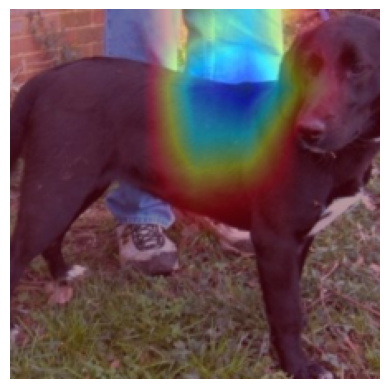

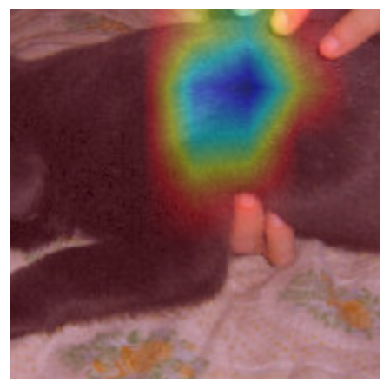

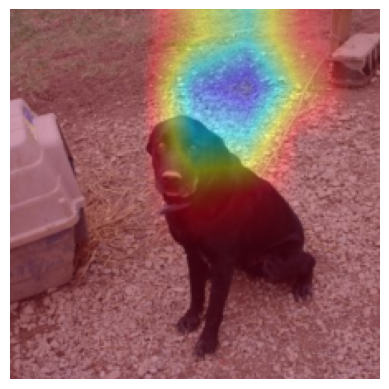

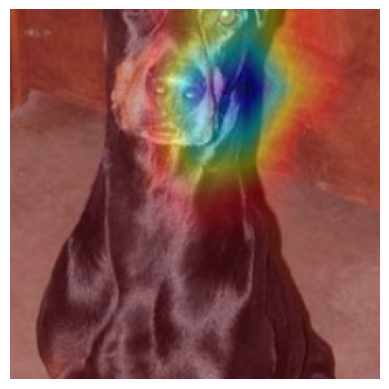

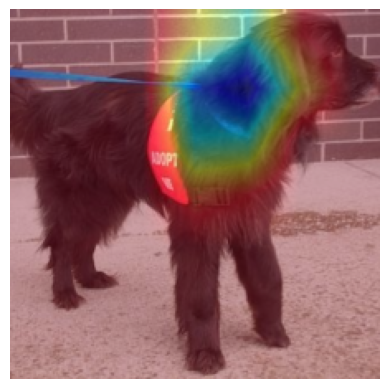

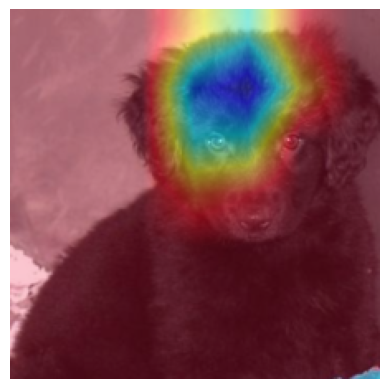

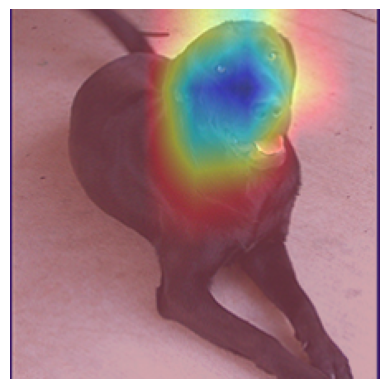

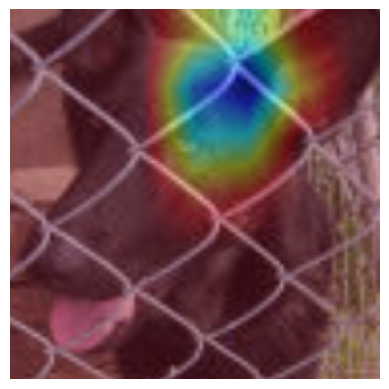

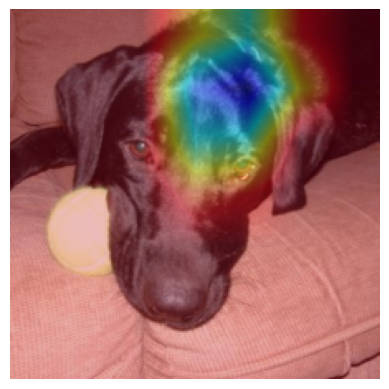

In [8]:
import cv2

class SimpleGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()


        target_layer = self.model.resnet50[-2][-1].conv3

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, input_tensor, class_idx):

        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = np.argmax(output.cpu().data.numpy())

        self.model.zero_grad()

        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        one_hot_output[0][class_idx] = 1

        output.backward(gradient=one_hot_output.to(output.device))

        # Generate heatmap
        gradients = self.gradients.cpu().numpy()[0]
        activations = self.activations.cpu().numpy()[0]
        pooled_gradients = np.mean(gradients, axis=(1, 2))

        for i in range(pooled_gradients.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = np.mean(activations, axis=0)
        heatmap = np.maximum(heatmap, 0)
        heatmap = heatmap / np.max(heatmap)

        return heatmap

def visualize_heatmap(heatmap, original_img, alpha=0.6):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + original_img
    plt.imshow(superimposed_img / superimposed_img.max())
    plt.axis('off')
    plt.show()

model = best_model
target_layer = model.resnet50[-1]  # Last layer

test_batch = next(iter(dataloader_test))
test_images = test_batch['input'].to(device)

test_image = test_images[0].unsqueeze(0)  # Add batch dimension

grad_cam = SimpleGradCAM(model)
heatmap = grad_cam.generate_heatmap(test_image, class_idx=None)  #  None for highest class

# Prepare original image for overlay
for i in range(1,10):
  original_image = test_images[i].cpu().data.numpy().transpose(1, 2, 0)
  original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min()) * 255
  original_image = np.uint8(original_image)

  visualize_heatmap(heatmap, original_image)

**Question 2: What do you think about the quality of the explanation of your classification.** (hint show cases where the CAM is not good enough)

In [9]:
# In the last question, we have plotted ten images using CAM to show the heat map
# that explains why the model classifies the image as a dog.

# In most of the cases, the classification is based on the head of the dog.
# But in some cases (image 1, 2 and 5), the explanation is not based on the head
# and is based on other parts that seem to be not sufficient to decide if it's a dog or not.
# This may show the limitation of CAM that couldn't characterize the region on which the model focused.

## 2 : Zeros Shot Classification with CLIP

CLIP (Contrastive Language-Image Pre-training) is a Foundation model developed by OpenAI that has garnered attention for its ability to perform zero-shot classification effectively. Zero-shot classification refers to the capability of a model to recognize and categorize objects or concepts it has never seen during training. CLIP achieves this by bridging the gap between vision and language.

At its core, CLIP is a vision-language model that learns to associate images and their corresponding textual descriptions. Unlike traditional models that rely solely on image data, CLIP is trained on a diverse set of internet images paired with natural language descriptions. This unique training approach allows CLIP to understand the context and relationships between images and their associated textual descriptions.

The key to CLIP's success in zero-shot classification lies in its ability to comprehend textual prompts. During inference, instead of relying solely on visual information, CLIP leverages its knowledge of language to understand the task at hand. This means that users can input textual descriptions or queries to guide CLIP in making predictions about images it has never encountered before.

For example, if CLIP is trained on images of various dog breeds with corresponding textual descriptions, it can successfully classify a new image of a dog even if it has not seen that specific breed during training. By understanding the language associated with images, CLIP generalizes well to novel scenarios, making it a powerful tool for zero-shot classification tasks.


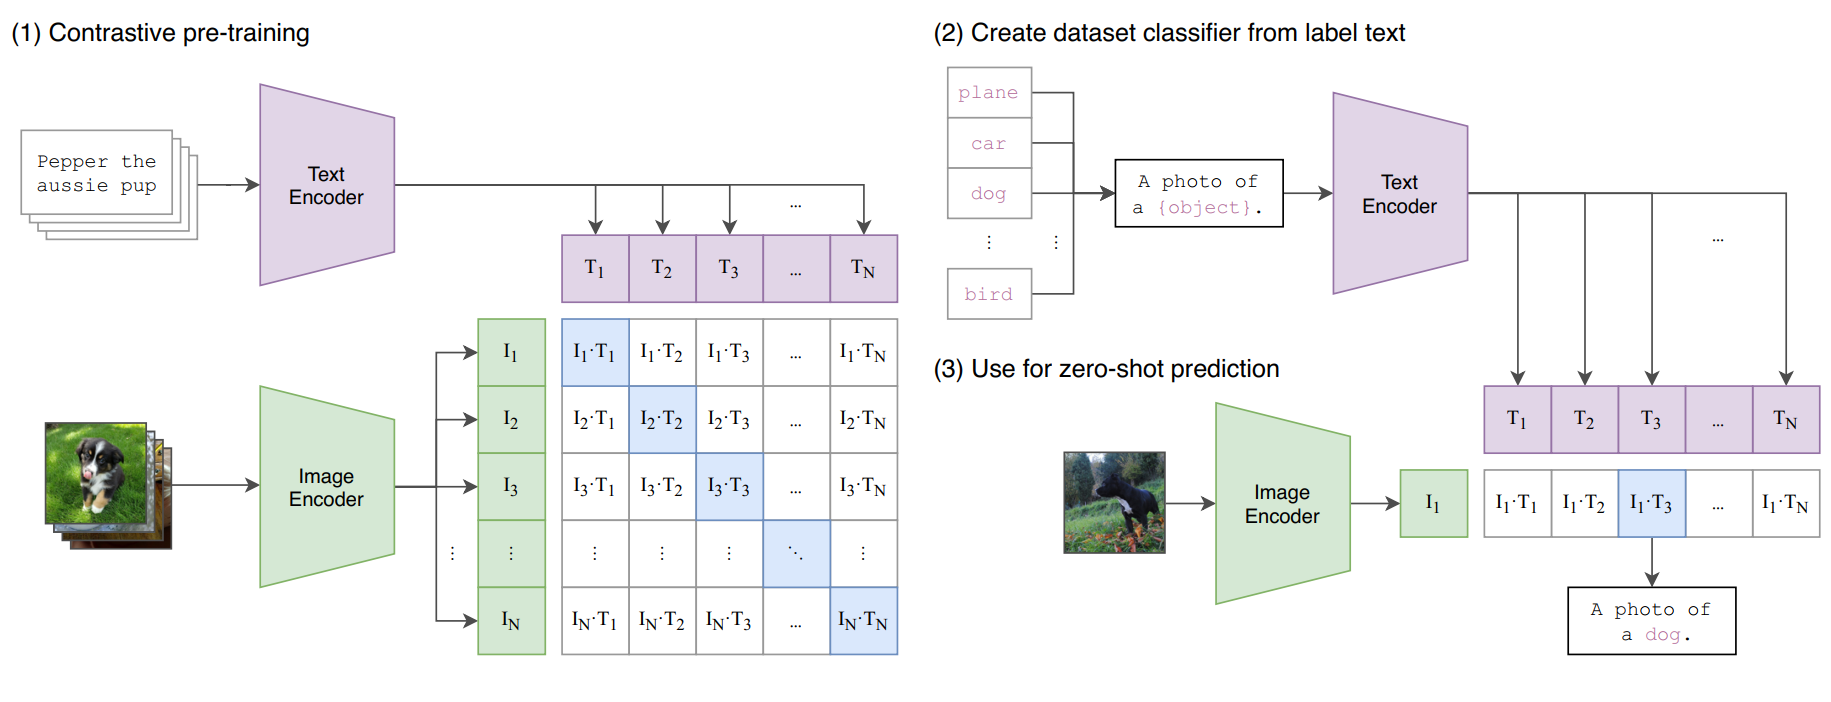

In [10]:
#!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-lti6ioy4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-lti6ioy4
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


**Question 3: please perform a zeros-shot classification with CLIP on the image just bellow.** We consider that you can choose among three classes cat, dog or car.

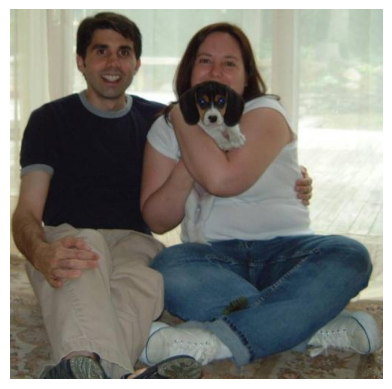

Predicted class: a cat with a confidence score of 0.8515625%
a car: 0.73%
a dog: 14.12%
a cat: 85.16%


In [11]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model and preprocessor
model_clip, preprocess_clip = clip.load("ViT-B/32", device=device)

# Define the list of classes
list_classes = ["a car", "a dog", "a cat"]

# Load the image
path_image = '/content/Cats_Dogs_Cars_Reduced/Dogs/White/9192.jpg'
image = preprocess_clip(Image.open(path_image)).unsqueeze(0).to(device)
image_show = Image.open(path_image)

# Perform zero-shot classification
text_tokens = clip.tokenize(list_classes).to(device)

# Calculate features
with torch.no_grad():
    image_features = model_clip.encode_image(image)
    text_features = model_clip.encode_text(text_tokens)

    # Pick the top class for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

plt.imshow(image_show)
plt.axis('off')
plt.show()

# Get the name of the top class
predicted_class = list_classes[indices[0].item()]

print(f"Predicted class: {predicted_class} with a confidence score of {values[0].item()}%")
# Print out the scores for all classes
for i, class_name in enumerate(list_classes):
    print(f"{class_name}: {similarity[0][i].item() * 100:.2f}%")


## 3 : CLIP zero shot

**Question 4: please perform a zeros show classification with CLIP on the test set.** What is your accuracy. What do you think about it.

In [12]:
# Define the evaluation fct
def evaluate_zero_shot_clip(dataloader, model, text_classes):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    n_success = 0
    text_tokens = clip.tokenize(text_classes).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    model.eval()
    for data in tqdm(dataloader, desc="Evaluating"):
        images = data['input'].to(device)
        labels = data['label'].to(device)
        # write the rest
        with torch.no_grad():
            image_features = model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)

            similarity = image_features @ text_features.T
            predictions = similarity.argmax(dim=-1)

            n_success += (predictions == labels).sum().item()

    return n_success/(len(dataloader)*dataloader.batch_size)

In [13]:


text = ["a dog", "a cat", "a car"]

evaluate_zero_shot_clip(dataloader_test,model_clip,text)


Evaluating: 100%|██████████| 11/11 [00:04<00:00,  2.66it/s]


0.9275568181818182

In [14]:
# We got as an accuracy 0.927 which is good for zeros shot classification.
# This accuracy shows the power of CLIP in learning accurate features.

## 4 : Classification avec CLIP + linear probing

Linear probing is commonly employed to evaluate the effectiveness of deep representations once the neural network has undergone sufficient training. This involves training an additional linear classifier on top of the pre-trained features. The parameters of the linear probe are initialized randomly, and the original classifier layer is disregarded. Importantly, the pre-trained backbone remains frozen and undergoes no further training during the linear probing phase.

In [15]:
# Dataset clip_embed
# this function should help you to extract the CLIP embedding
def extract_feature( model, dataloader):
    model.eval()

    batch_idx =0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Extracting'):
            image = data['input'].to(device)
            labels = data['label'].to(device)
            outputs  = model_clip.encode_image(image).squeeze(0)

            if batch_idx ==0:
              output_concat = outputs.detach().clone()
              target_concat = labels.clone()


            else:
              output_concat=torch.cat((output_concat, outputs.detach()), 0)
              target_concat=torch.cat((target_concat, labels), 0)
            batch_idx+=1


    return  output_concat,target_concat

In [16]:
class Dataset_from_tensor(torch.utils.data.Dataset):

    def __init__(self, data_feature, data_target,phase='label'):
        self.data_feature = data_feature
        self.data_target = data_target
        self.phase=phase

    def __len__(self):
        return len(self.data_feature)

    def __getitem__(self, index):
        # load data as tensor type (Height * Width * Channels)
        if self.phase=='label':
            data_feature = self.data_feature[index].float()
            data_target =  self.data_target[index]
            return {'input':data_feature,'label':data_target}

        else:
            data_feature = self.data_feature[index].float()
            return {'input':data_feature}

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:08<00:00,  1.30it/s]


**Question 5: please perform a linear probing classification with CLIP.**  You need to write the DNN and you need to train it. What is your accuracy. What do you think about it.

In [17]:
# Define the model and the optimizer
class linear_probe_img_embed(nn.Module):
  def __init__(self,device, output_dim,model_CLIP="ViT-B/32"):
    super(linear_probe_img_embed, self).__init__()
    self.fc = nn.Linear(512, output_dim)  # Assuming the embedding size is 512 for ViT-B/32

  def forward(self, embed):
    return self.fc(embed)




In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

List_classes = ['Dogs','Cats','Cars']
model_CLIP = 'ViT-B/32'

model = linear_probe_img_embed(device,len(List_classes),model_CLIP)
model.to(device)


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 376.58it/s]


Epoch [1/10] - Train Loss: 0.3707 - Train Acc: 94.62% - Val Loss: 0.2325 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 418.53it/s]


Epoch [2/10] - Train Loss: 0.1253 - Train Acc: 99.54% - Val Loss: 0.2316 - Val Acc: 99.23%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 309.14it/s]


Epoch [3/10] - Train Loss: 0.0926 - Train Acc: 99.54% - Val Loss: 0.2350 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 349.23it/s]


Epoch [4/10] - Train Loss: 0.0194 - Train Acc: 99.85% - Val Loss: 0.2320 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 395.60it/s]


Epoch [5/10] - Train Loss: 0.0269 - Train Acc: 99.74% - Val Loss: 0.3466 - Val Acc: 98.77%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 329.35it/s]


Epoch [6/10] - Train Loss: 0.0052 - Train Acc: 99.90% - Val Loss: 0.1906 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 424.29it/s]


Epoch [7/10] - Train Loss: 0.0083 - Train Acc: 99.95% - Val Loss: 0.2018 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 184.04it/s]


Epoch [8/10] - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 0.2056 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 181.05it/s]


Epoch [9/10] - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 0.2065 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 312.06it/s]


Epoch [10/10] - Train Loss: 0.0000 - Train Acc: 100.00% - Val Loss: 0.2067 - Val Acc: 98.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 401.59it/s]

Test Loss: 0.1790 - Test Acc: 99.39%


In [19]:
# We got as an accuracy 99.69 which is better than using CLIP alone.
# We can say that probing is helping to refine or enhance the representations learned by CLIP

## 5 : CLIP concept bottleneck model (CLIP-CBM)


Concept Bottleneck Models are a class of neural network architectures designed to capture and emphasize essential features or concepts within input data. In these models, a bottleneck layer is strategically placed within the network architecture, acting as a compression point that forces the network to distill and retain critical information while discarding less relevant details. The concept bottleneck serves as a conduit for information flow, ensuring that only the most discriminative features relevant to the task at hand pass through. By focusing on the extraction and representation of key concepts, these models aim to enhance interpretability, reduce overfitting, and promote generalization. Concept Bottleneck Models find applications in various domains, including computer vision and natural language processing, where the identification and utilization of high-level concepts are crucial for robust and effective learning.

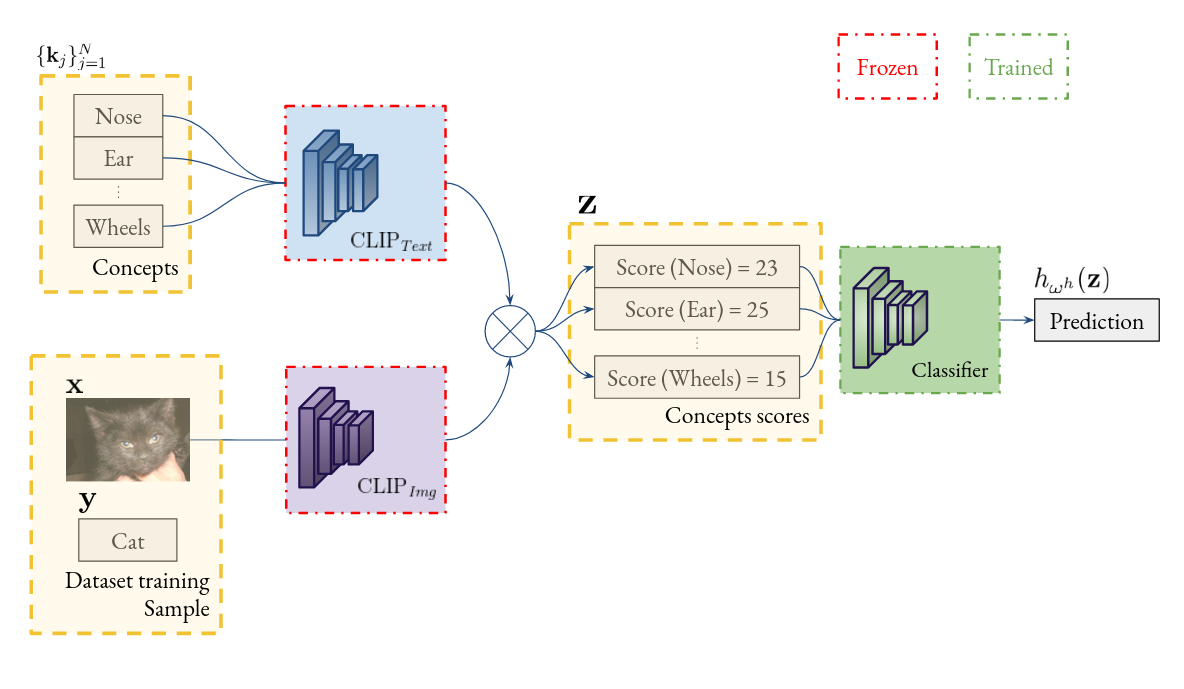

**question6 based on the figure above we want that you extract the a latent space that measure the similarity between the image and a set of concept. Then please write and train a concept bottleneck model.** You need to define the good set of concepts. Analyse your performences with different set of concepts. Compare to your results in question 4.

In [20]:
# Dataset z

List_concepts=['Black','White','Wood','Bottle','Cable']#,'a cat', 'a dog', 'a car'
#List_concepts['tail','bark','meowing','paws','long ears']
# you need to write clever concepts
text_featuresconcepts = clip.tokenize(List_concepts).to(device)
text_featuresconcepts = model_clip.encode_text(text_featuresconcepts).float() #.float()
text_featuresconcepts = text_featuresconcepts.float()
# Define the model and the optimizer
class CBM_Net(nn.Module):
  def __init__(self,device, output_dim,text_featuresconcepts):
    super().__init__()

    # text_features_concepts is a tensor of shape [num_concepts, concept_dim]
    self.text_features_concepts = text_featuresconcepts.detach()
    concept_dim = text_featuresconcepts.shape[0]

    # Define the concept bottleneck layer
    self.concept_layer = nn.Linear(concept_dim, output_dim)


  def forward(self, embed, return_concepts=False):
    embed = embed.to(torch.float32)
    similarities = torch.matmul(embed, self.text_features_concepts.T)
    logits = self.concept_layer(similarities)
    if return_concepts:
      return logits, similarities
    else:
      return logits

In [21]:
model_unbiaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_unbiaised.to(device)





# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_unbiaised.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_unbiaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_unbiaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_unbiaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 11/11 [00:00<00:00, 297.78it/s]


Epoch [1/10] - Train Loss: 6.7615 - Train Acc: 40.77% - Val Loss: 1.4189 - Val Acc: 54.15%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 395.40it/s]


Epoch [2/10] - Train Loss: 1.2591 - Train Acc: 51.59% - Val Loss: 1.2717 - Val Acc: 50.92%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 392.71it/s]


Epoch [3/10] - Train Loss: 0.8253 - Train Acc: 64.36% - Val Loss: 0.9143 - Val Acc: 61.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 385.82it/s]


Epoch [4/10] - Train Loss: 0.9599 - Train Acc: 60.82% - Val Loss: 0.7652 - Val Acc: 67.69%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 389.44it/s]


Epoch [5/10] - Train Loss: 1.2510 - Train Acc: 58.36% - Val Loss: 0.7446 - Val Acc: 69.54%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 367.30it/s]


Epoch [6/10] - Train Loss: 0.7255 - Train Acc: 68.56% - Val Loss: 0.8375 - Val Acc: 65.85%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 137.10it/s]


Epoch [7/10] - Train Loss: 0.7433 - Train Acc: 68.62% - Val Loss: 0.7340 - Val Acc: 68.62%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 206.74it/s]


Epoch [8/10] - Train Loss: 0.7589 - Train Acc: 67.74% - Val Loss: 0.7137 - Val Acc: 72.15%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 252.23it/s]


Epoch [9/10] - Train Loss: 0.7287 - Train Acc: 69.74% - Val Loss: 0.9643 - Val Acc: 64.00%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 330.80it/s]


Epoch [10/10] - Train Loss: 1.0615 - Train Acc: 61.85% - Val Loss: 2.3997 - Val Acc: 47.38%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 250.71it/s]

Test Loss: 2.2012 - Test Acc: 48.70%


In [22]:
# Comparing to the results of the question 4, we can say that we got lower accuracy.
# This is due to the fact that we trained with concepts not directed to the classes being studied.
# When we use concepts associated with one of the classes, the model will tend to categorize these classes
# and we'll get a better performance of the model.

**question7: normaly on the previous question you have trained with non biaised a dataset. Please add biaised with the color. For exemple all the object of one class have a color and retrain.** Analyse the results and explain it. Why did we do this experiment.

In [23]:
## train with the biaised dataset
color_white=True
if color_white:
  # generation of the dataloader for the 3 classes with all the color
  D_set_dogs = {'train':'White','val':'White','test':'Black+White'}
  D_set_cats = {'train':'White','val':'White','test':'Black+White'}
  D_set_cars = {'train':'Black','val':'Black','test':'Black+White'}
  #D_set_cars = {'train':'','val':'','test':''}

  root = '/content/drive/MyDrive/Cours/TP_XAI/Dataset'
  root = '/content/Cats_Dogs_Cars_Reduced'

  weights = ResNet50_Weights.DEFAULT
  preprocess_resnet = weights.transforms()

  Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
  Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
  Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])



  dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
  dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
  dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:04<00:00,  2.45it/s]


In [24]:
List_concepts=['Black','White','paws','meowing','tail']
text_featuresconcepts = clip.tokenize(List_concepts).to(device)
with torch.no_grad():
    text_featuresconcepts = model_clip.encode_text(text_featuresconcepts).float()
model_biaised = CBM_Net(device,len(List_classes),text_featuresconcepts)
model_biaised.to(device)




# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_biaised.parameters(), lr=0.2)
num_epochs = 10  # Set your desired number of epochs

for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model_biaised,dataloader_embed_train, criterion, optimizer,device)
    val_loss, val_acc = evaluate_model(model_biaised, dataloader_embed_val, criterion,device)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

# Test the trained model
test_loss, test_acc = evaluate_model(model_biaised, dataloader_embed_test, criterion,device)
print(f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

Evaluating: 100%|██████████| 5/5 [00:00<00:00, 415.43it/s]


Epoch [1/10] - Train Loss: 9.6155 - Train Acc: 45.28% - Val Loss: 8.3802 - Val Acc: 68.26%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 487.52it/s]


Epoch [2/10] - Train Loss: 5.8674 - Train Acc: 64.16% - Val Loss: 0.4686 - Val Acc: 79.52%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 456.12it/s]


Epoch [3/10] - Train Loss: 1.4631 - Train Acc: 70.42% - Val Loss: 0.2667 - Val Acc: 86.01%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 539.64it/s]


Epoch [4/10] - Train Loss: 0.2838 - Train Acc: 88.62% - Val Loss: 0.0896 - Val Acc: 98.29%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 518.51it/s]


Epoch [5/10] - Train Loss: 0.1238 - Train Acc: 96.36% - Val Loss: 0.0791 - Val Acc: 98.29%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 562.74it/s]


Epoch [6/10] - Train Loss: 0.1311 - Train Acc: 95.79% - Val Loss: 0.0738 - Val Acc: 97.61%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 558.20it/s]


Epoch [7/10] - Train Loss: 0.0800 - Train Acc: 98.07% - Val Loss: 0.1430 - Val Acc: 94.54%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 556.24it/s]


Epoch [8/10] - Train Loss: 0.0921 - Train Acc: 96.59% - Val Loss: 0.0832 - Val Acc: 96.59%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 533.49it/s]


Epoch [9/10] - Train Loss: 0.0815 - Train Acc: 98.18% - Val Loss: 0.1592 - Val Acc: 91.81%


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 520.13it/s]


Epoch [10/10] - Train Loss: 0.1073 - Train Acc: 96.36% - Val Loss: 0.1080 - Val Acc: 96.25%


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 387.33it/s]

Test Loss: 0.8161 - Test Acc: 76.95%


In [25]:
# In this part, it's totally normal to have a lower accuracy than the one in the question 7.
# This is due to the fact that we are adding a certain bias to the dataset to verify
# if the model colour is interfering in the class prediction or not.

**question8: please show the statistic of each concept on the latent space of for one class using a CBM** Analyse the results and explain it.




In [26]:
## With a biaised dataset
List_concepts=['Black','White','Wood','Bottle','Cable']
# generation of the dataloader for the 3 classes with all objects of one class having the same color
D_set_dogs = {'train':'White','val':'White','test':'Black+White'}
D_set_cats = {'train':'Black','val':'Black','test':'Black+White'}
D_set_cars = {'train':'White','val':'White','test':'Black+White'}

root = '/content/Cats_Dogs_Cars_Reduced'

Cats_Dogs_dataset_x_train = Cats_Dogs_dataset_x(root,'train',preprocess_resnet,set_dogs=D_set_dogs['train'],set_cats=D_set_cats['train'],set_cars=D_set_cars['train'])
Cats_Dogs_dataset_x_val = Cats_Dogs_dataset_x(root,'val',preprocess_resnet,set_dogs=D_set_dogs['val'],set_cats=D_set_cats['val'],set_cars=D_set_cars['val'])
Cats_Dogs_dataset_x_test = Cats_Dogs_dataset_x(root,'test',preprocess_resnet,set_dogs=D_set_dogs['test'],set_cats=D_set_cats['test'],set_cars=D_set_cars['test'])

dataloader_train = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_train,shuffle=True,batch_size=64)
dataloader_val = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_val,shuffle=True,batch_size=64)
dataloader_test = torch.utils.data.DataLoader(Cats_Dogs_dataset_x_test,shuffle=False,batch_size=64)

Clip_embeding_train,target_train= extract_feature(model_clip,dataloader_train)
Clip_embeding_val,target_val= extract_feature(model_clip, dataloader_val)
Clip_embeding_test,target_test= extract_feature(model_clip, dataloader_test)

dataloader_embed_train = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_train,target_train),shuffle=True,batch_size=64)
dataloader_embed_val = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_val,target_val),shuffle=True,batch_size=64)
dataloader_embed_test = torch.utils.data.DataLoader(Dataset_from_tensor(Clip_embeding_test,target_test),shuffle=False,batch_size=64)

Extracting: 100%|██████████| 11/11 [00:03<00:00,  2.88it/s]


In [27]:
import pandas as pd
def extract_concepts( model, dataloader):
    model.eval()

    batch_idx =0
    with torch.no_grad():
        for data in tqdm(dataloader, desc='Extracting'):
            image = data['input'].to(device)
            labels = data['label'].to(device)
            _ , outputs  = model(image, return_concepts=True)
            print(outputs)
            if batch_idx == 0:
                df = pd.DataFrame({'Black':outputs[:,0].cpu(),
                                   "White":outputs[:,1].cpu(),
                                   "Wood":outputs[:,2].cpu(),
                                   "Bottle":outputs[:,3].cpu(),
                                   "Cable":outputs[:,4].cpu(),
                                   "Class":[List_classes[i] for i in labels]})
            else:
                df1 = pd.DataFrame({'Black':outputs[:,0].cpu(),
                                   "White":outputs[:,1].cpu(),
                                   "Wood":outputs[:,2].cpu(),
                                   "Bottle":outputs[:,3].cpu(),
                                   "Cable":outputs[:,4].cpu(),
                                   "Class":[List_classes[i] for i in labels]})
                df = pd.concat([df,df1], ignore_index=True)

            batch_idx+=1

    return  df

In [28]:
df = extract_concepts(model_biaised, dataloader_embed_train)

Extracting:  84%|████████▍ | 16/19 [00:00<00:00, 75.34it/s]

tensor([[17.8652, 21.9791, 19.6014, 21.2944, 22.4089],
        [13.7429, 17.8484, 10.5291, 14.4830, 14.7263],
        [14.5860, 20.0663, 21.1433, 17.9984, 22.0726],
        [19.0098, 24.8510, 24.0815, 22.2946, 25.1141],
        [15.7747, 20.2042, 14.6709, 15.4252, 17.9896],
        [22.7674, 17.4998, 23.5422, 27.3988, 22.8773],
        [18.9270, 23.8219, 18.5112, 21.8343, 20.0760],
        [15.7780, 20.6528, 13.9601, 14.2280, 16.4039],
        [17.0564, 23.2284, 23.8924, 22.7017, 25.0170],
        [15.0549, 20.5438, 23.6143, 20.1206, 21.1042],
        [22.9205, 16.3368, 22.0579, 26.6324, 21.6565],
        [17.7936, 22.1036, 22.0067, 25.3072, 23.3129],
        [16.3808, 19.0728, 14.4492, 15.4542, 16.1073],
        [23.0518, 18.7230, 23.0662, 27.4077, 22.9265],
        [16.1192, 18.4918, 23.8070, 18.9879, 20.9062],
        [21.1514, 22.6005, 19.6115, 21.9241, 19.2135],
        [22.7561, 18.3056, 23.8479, 28.8707, 22.3603],
        [16.5088, 23.4202, 17.4834, 19.8222, 22.7028],
        [1

Extracting: 100%|██████████| 19/19 [00:00<00:00, 73.84it/s]

tensor([[20.1966, 24.9015, 25.3727, 23.6031, 22.9420],
        [15.4727, 18.6763, 13.2533, 16.3364, 16.8866],
        [23.8377, 18.7989, 23.6079, 28.9241, 23.5315],
        [16.0301, 20.1232, 15.0557, 17.6564, 16.9865],
        [21.1204, 24.7884, 19.9325, 21.7498, 24.0199],
        [18.8806, 23.4320, 17.7096, 22.1697, 21.4785],
        [20.1633, 24.6505, 19.5824, 23.7437, 22.7950],
        [16.7140, 21.3727, 15.7306, 17.2232, 20.0924],
        [21.1181, 24.7825, 24.8059, 24.7099, 22.4470],
        [14.5531, 15.7544, 15.2287, 15.9196, 16.1415],
        [23.4486, 17.8188, 23.3047, 28.3638, 22.0972],
        [22.9181, 17.8497, 25.6419, 27.9373, 27.0848],
        [24.1352, 17.8958, 25.1349, 29.0383, 22.1812],
        [19.7817, 24.0511, 24.6530, 21.9413, 23.3138],
        [16.0523, 19.6791, 21.8636, 20.5471, 19.6593],
        [16.5264, 19.0987, 24.3270, 20.0572, 20.2249],
        [20.0547, 27.2145, 21.0681, 22.6861, 25.3498],
        [16.5283, 21.0481, 23.3229, 22.1297, 24.1837],
        [2

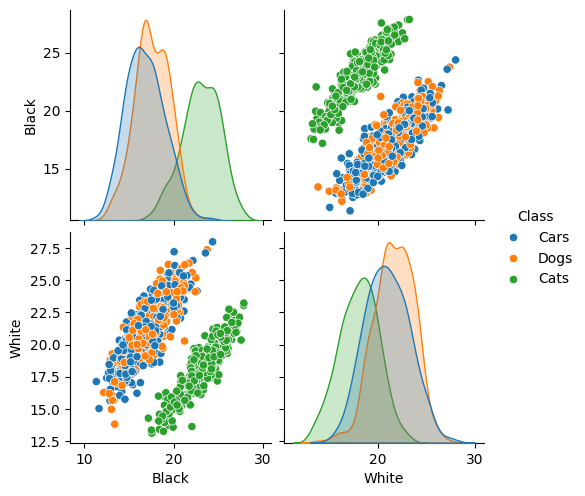

In [29]:
import seaborn as sns
sns.pairplot(df[['Black', 'White','Class']], hue='Class', palette='tab10')

## 6 : Méthodes d'explications Post-Hoc (LIME et SHAP)

**question9: please try to see  what explain could LIME provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for LIME :   https://github.com/marcotcr/lime


In [30]:


!pip install lime
!pip install shap
!pip install seaborn

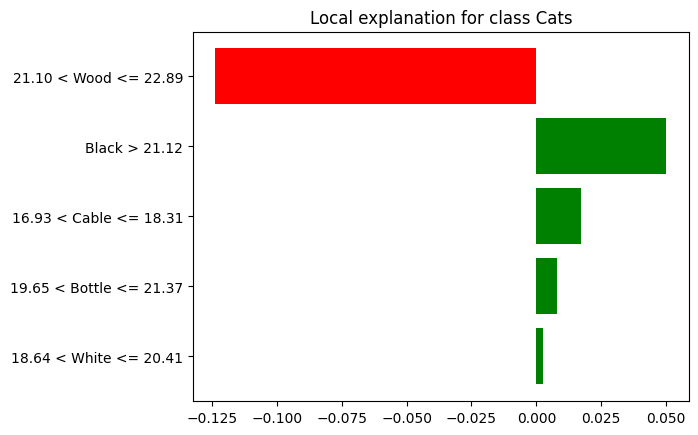

In [37]:
from lime import lime_tabular

_ , similarity_train = model_unbiaised.forward(Clip_embeding_train, return_concepts=True)
similarity_train = similarity_train.cpu().numpy()

explainer = lime_tabular.LimeTabularExplainer(similarity_train,
                                              feature_names=List_concepts,
                                              class_names=List_classes,
                                              mode='classification')
exp = explainer.explain_instance(data_row=similarity_train[0],
                                 predict_fn=lambda x:F.softmax(model_unbiaised.concept_layer(torch.Tensor(x).cuda())).detach().cpu().numpy(),
                                 labels = [target_train[0]],
                                 num_features=len(List_concepts))
exp.show_in_notebook(show_table=True)


In [38]:
# Here we have an example of an instance that was predicted as a car but we are analyzing
# the model's decision towards the class Dogs. We can clearly see that the two most accurate
# concepts (White and Black) are on the NOT Dogs side which can explain why the model gave to dogs
# a probability of 0.01

**question10: please try to see  what explain could SHAP provide if associate with the CBM** Could you do it without the CBM?

Have a look at this repo for shap :  https://github.com/shap/shap

In [39]:
import shap
model_unbiaised.eval()
background_data = Clip_embeding_train[:100].clone().detach()
background = background_data.to(device)
explainer = shap.DeepExplainer(model_unbiaised, background)
instance_to_explain = Clip_embeding_train[0:1].clone().detach()
instance = instance_to_explain.to(device)

shap_values = explainer.shap_values(instance)
assert shap_values[0].shape[1] == instance.shape[1], "SHAP values and instance features must have the same length"

shap_class_values = shap_values[0]

shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[0][0])


In [40]:
#

## 7 : Counterfactual (Au niveau de z)

**question11: please perform a counterfactual explanation.**



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



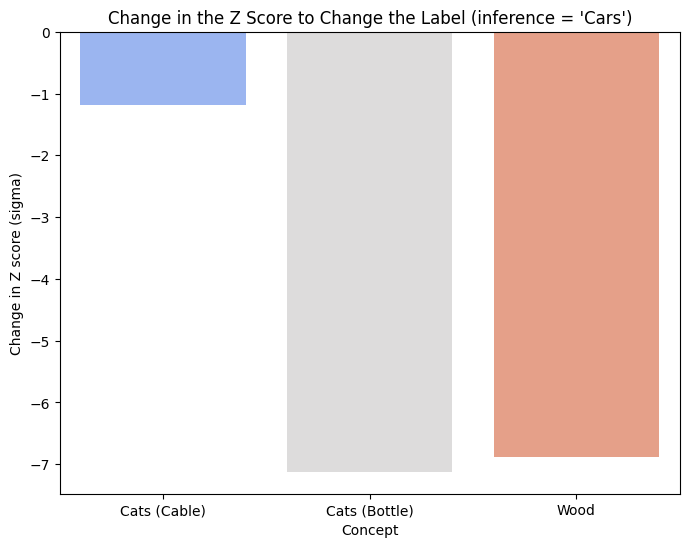

In [48]:
from torch.autograd import Variable

def extract_z_scores(model, dataloader, device):
    model.to(device)
    model.eval()
    all_z_scores = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input'].to(device)
            outputs = model(inputs)
            all_z_scores.append(outputs.cpu().numpy())
    return np.concatenate(all_z_scores)

def find_counterfactual(model, dataloader, device, target_class_idx, num_samples=5, max_iter=1000, learning_rate=0.01):
    z_scores = extract_z_scores(model, dataloader, device)
    model.to(device)
    model.eval()

    counterfactuals = []

    for batch in dataloader:
        # Select samples that are classified as 'Cars'
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)
        cars_mask = labels == target_class_idx

        inputs_var = Variable(inputs[cars_mask], requires_grad=True)

        # Find the counterfactuals
        for _ in range(max_iter):
            outputs = model(inputs_var)

            target_scores = outputs[:, target_class_idx]
            target_scores = torch.mean(target_scores)

            target_scores.backward()
            inputs_var.data += learning_rate * inputs_var.grad.data
            inputs_var.grad.data.zero_()

            with torch.no_grad():
                new_predictions = torch.argmax(model(inputs_var), dim=1)
                changed_predictions_mask = new_predictions != target_class_idx

                if changed_predictions_mask.any():
                    counterfactuals.extend(inputs_var[changed_predictions_mask].detach().cpu().numpy())
                    break

            if len(counterfactuals) >= num_samples:
                break

    return counterfactuals, z_scores
# Assuming 'List_classes' is a list of class names such as ['Dogs', 'Cats', 'Cars']
target_class = List_classes.index('Cars')  # Replace 'Cars' with the actual class name you're targeting

counterfactuals, z_scores = find_counterfactual(model_unbiaised, dataloader_embed_test, device, target_class)

avg_z_score_change = np.mean(z_scores, axis=0)


data = {
    'Concept': ['Cats (Cable)', 'Cats (Bottle)', 'Wood'],
    'sigma': avg_z_score_change
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Concept', y='sigma', data=df, palette='coolwarm')

plt.title("Change in the Z Score to Change the Label (inference = 'Cars')")
plt.xlabel('Concept')
plt.ylabel('Change in Z score (sigma)')

plt.show()